In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, cohen_kappa_score, matthews_corrcoef
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import itertools

# Adatbeolvasás

## Patientdata
Az eredeti csv feldolgozása már tanulásra előkészített adatokkal

In [2]:
readIn = pd.read_csv("data/df_patientdata.csv")
df_patientdata= pd.DataFrame(readIn)

In [3]:
df_patientdata.head(3)

,PatientID,Pathology,Is_Male,Age_Group_3,Age_Group_4,Age_Group_5,Age_Group_6,Age_Group_7,Age_Group_8
0,SCD0000101,1,1,False,False,True,False,False,False
1,SCD0000201,1,1,False,True,False,False,False,False
2,SCD0000301,1,1,False,False,False,False,True,False


## Image data
A dicom fájlokból egységesített, normalizált képek. 
- Numpy tömbben
- Méretük: (256,256)
- Minden pixelhez csak egy érték tartozik, értékük 0-1 között van

Disclaimer!! Ez pár percig el fog tartani

# Effective data loading

Load and train models in batches. The prepared data is stored in `data/images_splitX.npz`.

There are 12 data files:
- **0-8** for training the **individual models**
- **9-10** for training the **Voting classifier**
- **11** for **testing and evaluating**

The saved data is already shuffled.

In [4]:
# Read the first 9 datafiles for training
split_num=9

In [5]:
# Read a file with number
# Transform it to data to train with
def getXandY(splitNum):
    base_name='data/images'
    split_name = f'{base_name}_split{splitNum}.npz'
    data = np.load(split_name, allow_pickle=True)
    data_images=data['images']
    data_ids=data['ids']
    print(f'Merging         {splitNum}', end='\r')
    image_data=[]
    for id, image in zip(data_ids, data_images):
        image_data.append([id, image.flatten()])

    del data_images
    del data_ids

    df_images =pd.DataFrame(image_data, columns=['PatientID', 'Image'])

    del image_data
    
    merged_df = pd.merge(df_patientdata, df_images, on='PatientID', how='inner')

    X = merged_df.drop(['PatientID', 'Pathology'], axis=1)
    y = merged_df['Pathology']
    return X, y

# Training

## Individual model training

In [6]:
# Class responsible for training the individual models
class IndividualModelTrainer:
    def __init__(self, split_num):
        # How many datafiles to train with
        self.split_num = split_num
        # Random forest learning on images
        self.randomForest_i = RandomForestClassifier(n_estimators=20, warm_start=True)
        # Random forest learning on patient data
        self.randomForest_pd = RandomForestClassifier(n_estimators=20, warm_start=True)
        # Gradient boosting learning on patient data
        self.gradBoosting_pd = GradientBoostingClassifier(n_estimators=30, warm_start=True)
        # MLP classifier learning on images
        self.nn_i = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000, random_state=42)
        self.nn_initialized = False
        
    def training_for_sklearn(self):
        base_name='data/images'
        # Read datafile with id 'i'
        for i in range(split_num):
            print(f'Processing      {i}', end='\r')
            X_train, y_train = getXandY(i)
        
            X_image_train = X_train['Image'].tolist()
            X_patient_data_train = X_train.drop(['Image'], axis=1)
        
            print(f'Training images {i}', end='\r')
            self.train_image_classifiers(X_image_train, y_train)
            print(f'Training csv    {i}', end='\r')
            self.train_patient_data_classifiers(X_patient_data_train, y_train)

    def train_image_classifiers(self, X_image_train, y_train):
        self.randomForest_i.fit(X_image_train, y_train)
        # Add trees for incremental model training
        self.randomForest_i.n_estimators+=20
        # If neural network has been initialized
        if self.nn_initialized:
            self.nn_i.partial_fit(X_image_train, y_train)
        else:
            # If not yet initialized, provide the classes
            self.nn_i.partial_fit(X_image_train, y_train, classes=[0, 1, 2, 3])
            self.nn_initialized = True
        

    def train_patient_data_classifiers(self, X_patient_data_train, y_train):
        # Train models with patient data
        self.randomForest_pd.fit(X_patient_data_train, y_train)
        self.gradBoosting_pd.fit(X_patient_data_train, y_train)
        # Add trees for incremental model training
        self.randomForest_pd.n_estimators+=3
        self.gradBoosting_pd.n_estimators+=6

In [7]:
individualModelTrainer = IndividualModelTrainer(split_num)

In [8]:
# Individual model training
individualModelTrainer.training_for_sklearn()

## Voting classifier

### Load ensemble data

Load datafile 9 and 10 for ensemble training

In [9]:
X_train_9, y_train_9 = getXandY(9)
X_train_10, y_train_10 = getXandY(10)
X_train_ensemble = pd.concat([X_train_9, X_train_10], axis=0)
y_train_ensemble = pd.concat([y_train_9, y_train_10], axis=0)

### Create voting classifier

In [10]:
# Column selector is the first part for the voting classifier pipeline
# If it's an image estimator, it transforms the df to the image column
# If it's a patient data estimator, it transforms the df without an image column
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, imageSelector= False, isNn=False):
        self.imageSelector = imageSelector
        self.isNn = isNn

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.imageSelector:
            return X['Image'].tolist()
        return X.drop(['Image'], axis=1)

In [11]:
patient_data_transformer = ColumnSelector()
image_transformer = ColumnSelector(imageSelector=True)

In [12]:
# Voting classifier estimators
estimators = [
    ('gb_patient_data', Pipeline([('selector', patient_data_transformer), ('model', individualModelTrainer.gradBoosting_pd)])),
    ('rf_patient_data', Pipeline([('selector', patient_data_transformer), ('model', individualModelTrainer.randomForest_pd)])),
    ('rf_image', Pipeline([('selector', image_transformer), ('model', individualModelTrainer.randomForest_i)])),
    ('nn_image', Pipeline([('selector', image_transformer), ('model', individualModelTrainer.nn_i)])),
]

Soft voting so that the weaker patient data estimators won't overpower the more accurate estimators.

In [13]:
voting_classifier = VotingClassifier(estimators, voting='soft')

### Train voting classifier

In [14]:
voting_classifier.fit(X_train_ensemble, y_train_ensemble)

VotingClassifier(estimators=[('gb_patient_data',
                              Pipeline(steps=[('selector', ColumnSelector()),
                                              ('model',
                                               GradientBoostingClassifier(n_estimators=84,
                                                                          warm_start=True))])),
                             ('rf_patient_data',
                              Pipeline(steps=[('selector', ColumnSelector()),
                                              ('model',
                                               RandomForestClassifier(n_estimators=47,
                                                                      warm_start=True))])),
                             ('rf_image',
                              Pipeline(steps=[('selector',
                                               ColumnSelector(imageSelector=True)),
                                              ('model',
                                               RandomForestClassifier(n_estimators=200,
                                                                      warm_start=True))])),
                             ('nn_image',
                              Pipeline(steps=[('selector',
                                               ColumnSelector(imageSelector=True)),
                                              ('model',
                                               MLPClassifier(hidden_layer_sizes=(128,
                                                                                 64),
                                                             max_iter=1000,
                                                             random_state=42))]))],
                 voting='soft')

# Load test data

In [15]:
X_test, y_test = getXandY(11)

# Evaluation

In [16]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [17]:
def plot_roc_curve(y_true, y_pred_probs, classes, xlim=None, ylim=None):
    """
    This function plots the ROC curve for each class and allows zooming in on a specific area.
    """
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 6))
    lw = 2
    colors = ['darkorange', 'green', 'blue', 'red', 'purple'] 

    for i, color in zip(range(len(classes)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC ({}), area = {:.2f}'.format(classes[i], roc_auc[i]))

    if xlim:
        plt.xlim(xlim)
    else:
        plt.xlim([0.0, 1.0])

    if ylim:
        plt.ylim(ylim)
    else:
        plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

In [18]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    print(np.unique(y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=["Class 0", "Class 1", "Class 2", "Class 3"], normalize=True)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Precision, Recall, F1 Score
    precision = precision_score(y_test, y_pred, average='weighted')
    
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # ROC-AUC
    y_pred_probs = model.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr', average='weighted')
    
    y_true_binary = label_binarize(y_test, classes=[0, 1, 2, 3]) 
    plot_roc_curve(y_true_binary, y_pred_probs, classes=["Class 0", "Class 1", "Class 2", "Class 3"])

    # Example usage with custom axis limits
    # For example, xlim=(0.0, 0.5), ylim=(0.t, 1.0), to display the upper left corner of the curve(s)
    plot_roc_curve(y_true_binary, y_pred_probs, classes=["Class 0", "Class 1", "Class 2", "Class 3"], xlim=(0.0, 0.4), ylim=(0.6, 1.0))

    # Cohen's Kappa
    kappa = cohen_kappa_score(y_test, y_pred)

    # Matthew's Correlation Coefficient
    mcc = matthews_corrcoef(y_test, y_pred)
    
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1 Score: {:.4f}".format(f1))
    print("ROC-AUC: {:.4f}\n".format(roc_auc))
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Class 0", "Class 1", "Class 2", "Class 3"]))
    print("Cohen's Kappa: {:.4f}".format(kappa))
    print("Matthew's Correlation Coefficient: {:.4f}".format(mcc))

[0 1 2 3]
Normalized confusion matrix


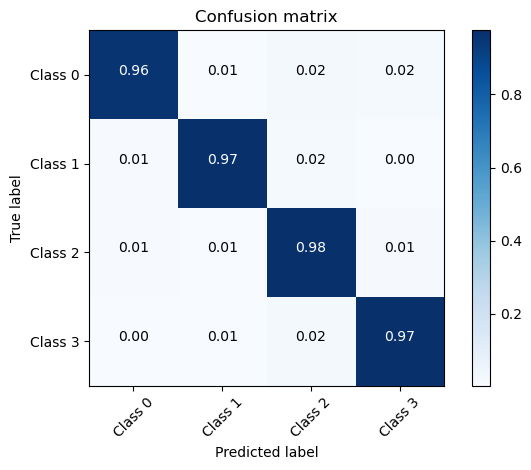

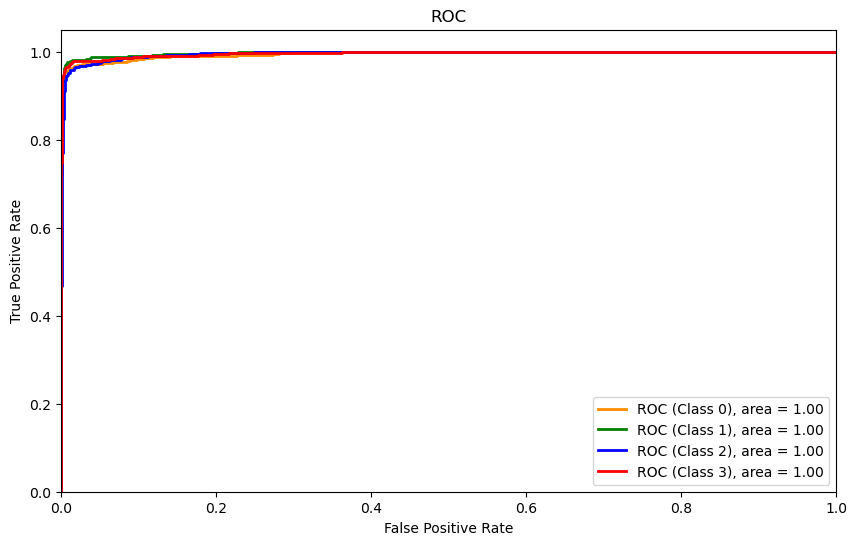

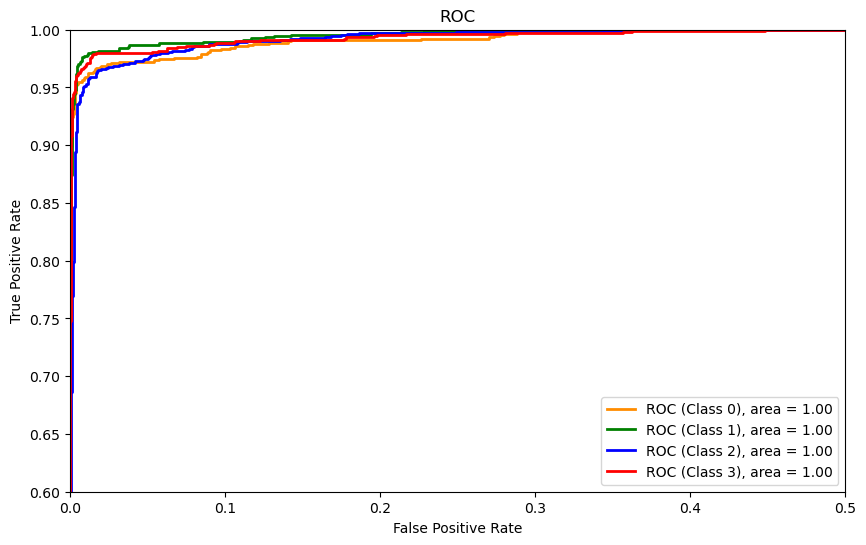

Accuracy: 0.9679
Precision: 0.9680
Recall: 0.9679
F1 Score: 0.9679
ROC-AUC: 0.9962

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.98      0.96      0.97       901
     Class 1       0.98      0.97      0.97       923
     Class 2       0.95      0.98      0.96      1176
     Class 3       0.97      0.97      0.97      1046

    accuracy                           0.97      4046
   macro avg       0.97      0.97      0.97      4046
weighted avg       0.97      0.97      0.97      4046

Cohen's Kappa: 0.9570
Matthew's Correlation Coefficient: 0.9570


In [19]:
evaluate_model(voting_classifier, X_test, y_test)

# Modell kimentése a Frontendhez

In [20]:
joblib.dump(voting_classifier, 'voting_classifier.joblib')

['voting_classifier.joblib']